In [112]:
# TODO CV with HYPERPARAMETERS + keep best 

In [113]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.decomposition import PCA

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier


In [114]:
def generate_data_20d():
    X, y = make_classification(n_samples=5000, n_features=20, n_informative=16, n_redundant=2, n_repeated=2, n_classes=2, weights=[0.95, 0.05], random_state=0) 
    return X, y

def generate_data_2d():
    X, y = make_classification(n_samples=5000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, weights=[0.95, 0.05], random_state=0) 
    return X, y

X, y = generate_data_2d()
#X, y = generate_data_20d()


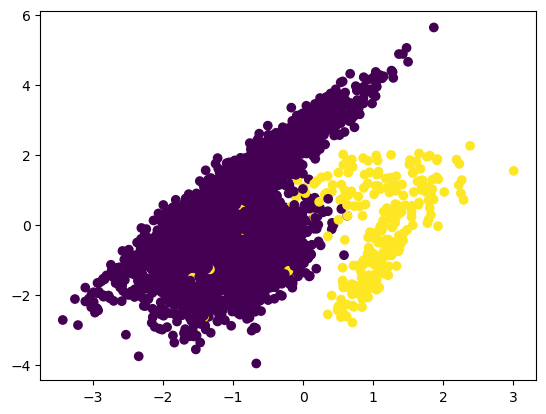

In [115]:
if (X.shape[1]!=2):
    # if more than 2 dimensions
    # make a PCA and plot 2 top components
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    total_var = pca.explained_variance_ratio_.sum() * 100
    print(f"PCA: Top 2 components explain {total_var:.0f}% of variance")

    plt.scatter(components[:,0],components[:,1],c=y)
else:
    # otherwise simply plot 2d data as scatter plot
    plt.scatter(X[:,0],X[:,1],c=y)


In [116]:
# classification routine

def classify(X, y, clf):

    #print(f"Samples of class 0: {y.shape[0] - np.sum(y)}")
    #print(f"Samples of class 1: {np.sum(y)}")

    # Defines the model to be used
    model = clf
    
    avg_accuracy = []
    avg_precision = []
    avg_recall = []
    avg_f1score = []
    avg_fbetascore = []
    avg_balanced_accuracy = []

    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.10, random_state=0, stratify=y)

    #print(f"Hold out samples of class 0: {y_hold.shape[0] - np.sum(y_hold)}")
    #print(f"Hold out samples of class 1: {np.sum(y_hold)}")

    
    # Defines Stratified K-fold in order to keep
    # the class balance for each fold
    st_k_fold = StratifiedKFold(n_splits=4)
   
    # average of folds
    for train_idx, test_idx in st_k_fold.split(X_train, y_train):
        
        # Training fold
        x_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        
        # Testing fold
        x_test_fold = X_train[test_idx]
        y_test_fold = y_train[test_idx]

        # Train
        model.fit(x_train_fold, y_train_fold)
        y_hat_fold = model.predict(x_test_fold)
        
        # Get metrics
        accuracy = accuracy_score(y_test_fold, y_hat_fold)
        precision = precision_score(y_test_fold, y_hat_fold)
        recall = recall_score(y_test_fold, y_hat_fold)
        f1score = f1_score(y_test_fold, y_hat_fold)
        fbetascore = fbeta_score(y_test_fold, y_hat_fold, beta=0.5)
        balanced_accuracy = balanced_accuracy_score(y_test_fold, y_hat_fold)

        # Save metrics
        avg_accuracy.append(accuracy)
        avg_precision.append(precision)
        avg_recall.append(recall)
        avg_f1score.append(f1score)
        avg_fbetascore.append(fbetascore)
        avg_balanced_accuracy.append(balanced_accuracy)
            

    metrics_train = []
    metrics_train.append(np.mean(avg_accuracy))
    metrics_train.append(np.mean(avg_precision))
    metrics_train.append(np.mean(avg_recall))
    metrics_train.append(np.mean(avg_f1score))
    metrics_train.append(np.mean(avg_fbetascore))
    metrics_train.append(np.mean(avg_balanced_accuracy))
#    print(f"Avg accuracy: {metrics_train[0]:.3f}")
#    print(f"Avg precision: {metrics_train[1]:.3f}")
#    print(f"Avg recall: {metrics_train[2]:.3f}")
#    print(f"Avg f1-score: {metrics_train[3]:.3f}")
#    print(f"Avg fbeta-score: {metrics_train[4]:.3f}")
#    print(f"Avg balanced accuracy: {metrics_train[5]:.3f}")
    
    # retrain on the whole train dataset and get scores on hold out
    model.fit(X_train, y_train)
    y_hat_hold = model.predict(X_hold)
    metrics_hold_out=[]
    metrics_hold_out.append(accuracy_score(y_hold, y_hat_hold))
    metrics_hold_out.append(precision_score(y_hold, y_hat_hold))
    metrics_hold_out.append(recall_score(y_hold, y_hat_hold))
    metrics_hold_out.append(f1_score(y_hold, y_hat_hold))
    metrics_hold_out.append(fbeta_score(y_hold, y_hat_hold, beta=0.5))
    metrics_hold_out.append(balanced_accuracy_score(y_hold, y_hat_hold))
#    print(f"Hold-out accuracy: {metrics_hold_out[0]:.3f}")
#    print(f"Hold-out precision: {metrics_hold_out[1]:.3f}")
#    print(f"Hold-out recall: {metrics_hold_out[2]:.3f}")
#    print(f"Hold-out f1-score: {metrics_hold_out[3]:.3f}")
#    print(f"Hold-out fbeta-score: {metrics_hold_out[4]:.3f}")
#    print(f"Hold-out balanced accuracy: {metrics_hold_out[5]:.3f}")
    
    return metrics_train, metrics_hold_out
    
    

In [117]:

# Applies clf without touching the data.
def dummy_clf(x, y, clf):
    return classify(x, y, clf)

# Applies Random Undersampling
def under_sampler(x, y, clf):
    rus = RandomUnderSampler()
    x, y = rus.fit_resample(x, y)
    return classify(x, y, clf)

# Applies Random Undersampling
def over_sampler(x, y, clf):
    ros = RandomOverSampler()
    x, y = ros.fit_resample(x, y)
    return classify(x, y, clf)

# Applies Synthetic Data Augmentation through SMOTE
def smote(x, y, clf):
    smote= SMOTE()
    x, y = smote.fit_resample(x, y)
    return classify(x, y, clf)

In [118]:

clfs = []
clfs.append(DecisionTreeClassifier(max_depth=3, random_state=0))
clfs.append(DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=0))
clfs.append(RandomForestClassifier(max_depth=3, random_state=0))
clfs.append(RandomForestClassifier(max_depth=3, class_weight="balanced", random_state=0))
clfs.append(make_pipeline(StandardScaler(), SVC(gamma='auto', random_state=0)))
clfs.append(make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight="balanced", random_state=0)))
clfs.append(BalancedRandomForestClassifier(n_estimators=100, random_state=0))

for clf in clfs:
    print(f"Model            t_acc t_pre t_rec t_f1  t_fb  t_bac \
    h_acc h_pre h_rec h_f1  h_fb  h_bac")
    #
    metrics_train, metrics_hold_out = dummy_clf(X, y, clf)
    print(f"{str(clf)[0:10]} dummy {metrics_train[0]:.3f} {metrics_train[1]:.3f} {metrics_train[2]:.3f} {metrics_train[3]:.3f} {metrics_train[4]:.3f} {metrics_train[5]:.3f} \
    {metrics_hold_out[0]:.3f} {metrics_hold_out[1]:.3f} {metrics_hold_out[2]:.3f} {metrics_hold_out[3]:.3f} {metrics_hold_out[4]:.3f} {metrics_hold_out[5]:.3f}")
    #
    metrics_train, metrics_hold_out = under_sampler(X, y, clf)
    print(f"{str(clf)[0:10]} under {metrics_train[0]:.3f} {metrics_train[1]:.3f} {metrics_train[2]:.3f} {metrics_train[3]:.3f} {metrics_train[4]:.3f} {metrics_train[5]:.3f} \
    {metrics_hold_out[0]:.3f} {metrics_hold_out[1]:.3f} {metrics_hold_out[2]:.3f} {metrics_hold_out[3]:.3f} {metrics_hold_out[4]:.3f} {metrics_hold_out[5]:.3f}")
    #
    metrics_train, metrics_hold_out = over_sampler(X, y, clf)
    print(f"{str(clf)[0:10]} over  {metrics_train[0]:.3f} {metrics_train[1]:.3f} {metrics_train[2]:.3f} {metrics_train[3]:.3f} {metrics_train[4]:.3f} {metrics_train[5]:.3f} \
    {metrics_hold_out[0]:.3f} {metrics_hold_out[1]:.3f} {metrics_hold_out[2]:.3f} {metrics_hold_out[3]:.3f} {metrics_hold_out[4]:.3f} {metrics_hold_out[5]:.3f}")
    #
    metrics_train, metrics_hold_out = smote(X, y, clf)
    print(f"{str(clf)[0:10]} smote {metrics_train[0]:.3f} {metrics_train[1]:.3f} {metrics_train[2]:.3f} {metrics_train[3]:.3f} {metrics_train[4]:.3f} {metrics_train[5]:.3f} \
    {metrics_hold_out[0]:.3f} {metrics_hold_out[1]:.3f} {metrics_hold_out[2]:.3f} {metrics_hold_out[3]:.3f} {metrics_hold_out[4]:.3f} {metrics_hold_out[5]:.3f}")


Model            t_acc t_pre t_rec t_f1  t_fb  t_bac     h_acc h_pre h_rec h_f1  h_fb  h_bac
DecisionTr dummy 0.987 0.937 0.824 0.873 0.909 0.910     0.994 0.929 0.963 0.945 0.935 0.979
DecisionTr under 0.937 0.986 0.885 0.932 0.963 0.937     0.964 1.000 0.926 0.962 0.984 0.963
DecisionTr over  0.941 0.974 0.907 0.939 0.960 0.941     0.934 0.995 0.873 0.930 0.968 0.934
DecisionTr smote 0.946 0.981 0.909 0.944 0.966 0.946     0.936 0.977 0.892 0.933 0.959 0.936
Model            t_acc t_pre t_rec t_f1  t_fb  t_bac     h_acc h_pre h_rec h_f1  h_fb  h_bac
DecisionTr dummy 0.976 0.776 0.845 0.797 0.781 0.914     0.974 0.684 0.963 0.800 0.726 0.969
DecisionTr under 0.924 0.969 0.877 0.919 0.948 0.924     0.964 1.000 0.926 0.962 0.984 0.963
DecisionTr over  0.943 0.967 0.917 0.941 0.957 0.943     0.938 0.958 0.915 0.936 0.949 0.938
DecisionTr smote 0.945 0.974 0.914 0.943 0.962 0.945     0.938 0.962 0.911 0.936 0.951 0.938
Model            t_acc t_pre t_rec t_f1  t_fb  t_bac     h_acc h_pre h